In [1]:
import DeepLabModel
import os, urllib
from PIL import Image
from io import BytesIO
import numpy as np
from skimage.io import imshow
import matplotlib.pyplot as plt
from matplotlib import gridspec
from ipywidgets import FloatSlider, interact, fixed, HBox, VBox, Label, Button, Output, IntProgress, FloatProgress
%pdb 0
plt.rcParams['figure.max_open_warning'] = False
import pandas as pd
import IPython
%matplotlib inline
from skimage.measure import label

from DCSegUtils import softmax
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib import colors

import seaborn as sb
import pandas as pd

Automatic pdb calling has been turned OFF


# Combining Segmentation models using Cooperative Negotiation

## Agents and Mediator definition

In [2]:
class Agent():
    def __init__(self, agentname, model, alpha_fun):
        self.agentname=agentname
        self.model=model
        self.task = None
        self.initial_proposal = None
        self.alpha = alpha_fun
        
    def new_task(self, image):
        self.task, logits = self.model.run(image)
        logits=logits[:self.task.size[1], :self.task.size[0], ...] # Otherwise logits are a square matrix
        self.initial_proposal = softmax(logits, axis=-1)
        self.last_proposal = self.initial_proposal
        return self.initial_proposal
    
    def utility(self, proposal):
        'Returns a utility of shape (labels) between a proposal and self.optimal'
        return np.array([np.linalg.norm(self.optimal[...,l]-proposal[...,l]) for l in range(self.optimal.shape[-1])])
    
    def propose(self, agreement):
        self.last_agreement = agreement
        self.last_proposal = self.last_proposal + self.alpha(self.last_proposal)*(agreement - self.last_proposal)
        
        return self.last_proposal
    

In [3]:
class Mediator():
    def __init__(self, agents):
        self.agents = agents
        self.last_step=0
        self.W = None
        
    def start_new_task(self, image):
        self.task = image
        self.initial_proposals = np.array([agent.new_task(self.task) for agent in self.agents])
        self.last_proposals = self.initial_proposals
        self.W = np.ones_like(self.initial_proposals)
        return self.last_proposals

        
    def negotiation(self, task, timeout = 100):
        for i in range(self.last_step, self.last_step+timeout):
            if i==0:
                self.last_proposals = self.start_new_task(task)
            else:
                # Propose the new agreement to the agents
                self.last_proposals = np.array([agent.propose(self.last_agreement) for agent in self.agents]) # ((p0, u0), (p1, u1), ...)

            self.last_step = i            
            self.last_agreement = np.divide(np.sum(self.last_proposals*self.W, axis=0), np.sum(self.W, axis=0))
                        
            yield self.last_agreement, self.last_proposals
        return self.last_agreement, self.last_proposals

### Loading Deep Learning Models

In [4]:
def load_models():    
    _DOWNLOAD_URL_PREFIX = 'http://download.tensorflow.org/models/'
    model_dir = '../models/'
    _MODEL_URLS = {
        'mobilenetv2_coco_voctrainaug':
            'deeplabv3_mnv2_pascal_train_aug_2018_01_29.tar.gz',
        'mobilenetv2_coco_voctrainval':
            'deeplabv3_mnv2_pascal_trainval_2018_01_29.tar.gz',
        'xception_coco_voctrainaug':
            'deeplabv3_pascal_train_aug_2018_01_04.tar.gz',
        'xception_coco_voctrainval':
            'deeplabv3_pascal_trainval_2018_01_04.tar.gz',
    }
    models = dict()
    for modelname, tarname in _MODEL_URLS.items():
        download_path = os.path.join(model_dir, tarname)
        if not os.path.isfile(download_path):
            print('downloading {}, this might take a while...'.format(modelname))
            urllib.request.urlretrieve(_DOWNLOAD_URL_PREFIX + _MODEL_URLS[modelname],
                               download_path)
            print('download completed!')
            
        else:
            print("model already present at {}".format(download_path))
        
        print('Loading model {}...'.format(modelname))
        models[modelname] = DeepLabModel.DeepLabModel(download_path)
        print('{} loaded successfully!'.format(modelname))
    return models
models = load_models()

model already present at ../models/deeplabv3_pascal_train_aug_2018_01_04.tar.gz
Loading model xception_coco_voctrainaug...
xception_coco_voctrainaug loaded successfully!
model already present at ../models/deeplabv3_mnv2_pascal_trainval_2018_01_29.tar.gz
Loading model mobilenetv2_coco_voctrainval...
mobilenetv2_coco_voctrainval loaded successfully!
model already present at ../models/deeplabv3_mnv2_pascal_train_aug_2018_01_29.tar.gz
Loading model mobilenetv2_coco_voctrainaug...
mobilenetv2_coco_voctrainaug loaded successfully!
model already present at ../models/deeplabv3_pascal_trainval_2018_01_04.tar.gz
Loading model xception_coco_voctrainval...
xception_coco_voctrainval loaded successfully!


In [5]:

LABEL_NAMES = np.asarray([
    'background', 'aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus',
    'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike',
    'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tv'
])
FULL_LABEL_MAP = np.arange(len(LABEL_NAMES)).reshape(len(LABEL_NAMES), 1)
FULL_COLOR_MAP = DeepLabModel.label_to_color_image(FULL_LABEL_MAP)

### Defining agent parameters

In [6]:
loaded = pd.read_csv('params.csv', index_col=0)

In [7]:

alphasliders = {m:[FloatSlider(description=l, min=0., max=1., step=0.01, value=loaded.loc[m][l]) for l in LABEL_NAMES] for m in models.keys()}
sliders = [VBox([Label(model)]+alphasliders[model]) for model in alphasliders.keys()]
HBox(sliders)

## Input Image

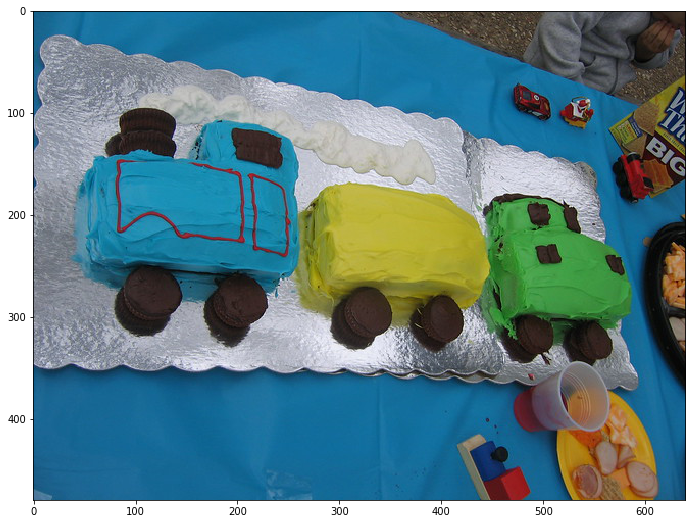

In [8]:
# Download an image and start negotiation
# Train pic bw
#url = 'https://farm9.staticflickr.com/8401/10174115513_13c3650c08_z.jpg'
# Person shadows
#url = 'http://farm8.static.flickr.com/7920/47425338881_de208df2ff_m.jpg'
# Train cake
url = 'http://farm6.staticflickr.com/5165/5379358886_eee5b992ee_z.jpg'

f = urllib.request.urlopen(url)
jpeg_str = f.read()
original_im = Image.open(BytesIO(jpeg_str))

plt.figure(figsize=(16,9));
plt.imshow(original_im)

MAX_STEPS=50

## Baseline
Alpha values are the validation accuracies for each model

In [9]:
def alpha_funcs_val():
    '''Definitions of the alpha_fun for each model. An alpha_fun takes the last proposal as input and outputs a value alpha for each pixel'''
    alpha_acc = {m: [1-slider.value for slider in alphasliders[m]] for m in alphasliders.keys()}
    functions = {modelname: lambda x, v=values: np.array(v) for (modelname, values) in alpha_acc.items()}
    return functions

alpha_v = alpha_funcs_val()
agents_v = [Agent(modelname, model, alpha_v[modelname]) for modelname, model in models.items()]
mediator_v = Mediator(agents_v)
print("Mediator Running")

status_v = Label("Idle")
display(status_v)
step_progress_v = IntProgress(max=1)
display(step_progress_v)

grid_spec = None
from ipywidgets import IntText
agreements_v = list()
proposals_v = list()

next_step_v = enumerate(mediator_v.negotiation(original_im, timeout=MAX_STEPS))
def run_negotiation_v(n):
    step_progress_v.max = n-1
    for i, (agreement, proposals) in next_step_v:
        step_progress_v.value = i
        status_v.value = "Running step {} of {}".format(i+1, MAX_STEPS)
        agreements_v.append(agreement)
        proposals_v.append(proposals)
    status_v.value = "Saving results.."
    np.save('results/agreements_v.npy', np.asarray(agreements_v))
    np.save('results/proposals_v.npy', np.asarray(proposals_v))
    status_v.value = "Idle"
    print("Agreements and Proposal saved in result folder")
#interact(run_negotiation_v, n=IntText(value=1));
run_negotiation_v(MAX_STEPS)

Mediator Running


Label(value='Idle')

IntProgress(value=0, max=1)

Agreements and Proposal saved in result folder


## Entropy (Pixels)
Alpha values are the entropy over the classes for each pixel in the last proposal

In [10]:
def alpha_funcs_ep():
    '''Definitions of the alpha_fun for each model. An alpha_fun takes the last proposal as input and outputs a value alpha for each pixel'''
    def entropy_over_pixels(last_proposal):
        n_labels = last_proposal.shape[-1]
        entr = lambda x, base=n_labels: -np.sum(x*np.log(x)/np.log(base),axis=-1)
        entr_over_pixels = entr(last_proposal)
        return np.expand_dims(entr_over_pixels, axis=-1)
    
    return {modelname: entropy_over_pixels for modelname in models.keys()}
alpha_ep = alpha_funcs_ep()
agents_ep = [Agent(modelname, model, alpha_ep[modelname]) for modelname, model in models.items()]
mediator_ep = Mediator(agents_ep)
print("Mediator Running")

status_ep = Label("Idle")
display(status_ep)
step_progress = IntProgress(max=1)
display(step_progress)


grid_spec = None
from ipywidgets import IntText
agreements_ep = list()
proposals_ep = list()

next_step = enumerate(mediator_ep.negotiation(original_im, timeout=MAX_STEPS))
def run_negotiation_ep(n):
    step_progress.max = n-1
    for i, (agreement, proposals) in next_step:
        step_progress.value = i
        status_ep.value = "Running step {} of {}".format(i+1, MAX_STEPS)
        agreements_ep.append(agreement)
        proposals_ep.append(proposals)
        
    status_ep.value = "Saving results.."
    np.save('results/agreements_ep.npy', np.asarray(agreements_ep))
    np.save('results/proposals_ep.npy', np.asarray(proposals_ep))
    status_ep.value = "Idle"
    print("Agreements and Proposal saved in result folder")
#interact(run_negotiation_ei, n=IntText(value=1));
run_negotiation_ep(MAX_STEPS)

Mediator Running


Label(value='Idle')

IntProgress(value=0, max=1)

Agreements and Proposal saved in result folder


## Entropy (Image)
Alpha values are the entropy over the classes of the whole image representing last proposal

In [11]:
def alpha_funcs_ei():
    '''Definitions of the alpha_fun for each model. An alpha_fun takes the last proposal as input and outputs a value alpha for each pixel'''
    from scipy.stats import entropy
    def entropy_over_image(last_proposal):
        n_labels = last_proposal.shape[-1]
        entr = lambda x, base=n_labels: -np.sum(x*np.log(x)/np.log(base),axis=-1)
        entr_over_pixels = entr(last_proposal)
        return np.mean(entr_over_pixels)   
    return {model_name: entropy_over_image for model_name in models.keys()}

alpha_ei = alpha_funcs_ei()
agents_ei = [Agent(modelname, model, alpha_ei[modelname]) for modelname, model in models.items()]
mediator_ei = Mediator(agents_ei)
print("Mediator Running")


status_ei = Label("Idle")
display(status_ei)
step_progress_ei = IntProgress(max=1)
display(step_progress_ei)
display(Label("Total Progress"))

grid_spec = None
from ipywidgets import IntText
agreements_ei = list()
proposals_ei = list()

next_step_ei = enumerate(mediator_ei.negotiation(original_im, timeout=MAX_STEPS))
def run_negotiation_ei(n):
    step_progress_ei.max = n-1
    for i, (agreement, proposals) in next_step_ei:
        step_progress_ei.value = i
        status_ei.value = "Running step {} of {}".format(i+1, MAX_STEPS)
        agreements_ei.append(agreement)
        proposals_ei.append(proposals)
        
        
    status_ei.value = "Saving results.."
    np.save('results/agreements_ei.npy', np.asarray(agreements_ei))
    np.save('results/proposals_ei.npy', np.asarray(proposals_ei))
    status_ei.value = "Idle"
    print("Agreements and Proposal saved in result folder")

#interact(run_negotiation_ei, n=IntText(value=1));
run_negotiation_ei(MAX_STEPS)

Mediator Running


Label(value='Idle')

IntProgress(value=0, max=1)

Label(value='Total Progress')

Agreements and Proposal saved in result folder
